# T-prime and T-ref calculation

This notebook will guide you through the processing of $ T_{ref} $ and $ T_{p} $ on both reanalysis and CIMP6 models. The process relies heavily on Dask `job-queue` and uses all the power of RCCs Midway to parallelize the code and get fast calculations. Be mindful that to reproduce this code you need to correctly configure `job-queue` by changing the `jobqueue.yaml` file (usually is in this path: in `$HOME/.config/dask/`). 

A small example of this configuration file is this one: 

```yaml
jobqueue:
  slurm:
    name: dask-worker

    # Dask worker options
    cores: 28                  # Total number of cores per job
    memory: '64GB'             # Total amount of memory per job
    processes: 1               # Number of Python processes per job
    n_workers: 0
    nanny: false
    job_extra:
        - '--account=geos39650'
        - '--output=dask_worker.out'
        - '--error=dask_worker.err'

    interface: ib0
    local-directory: $SCRATCH$ 
    queue: 'broadwl'
    walltime: '00:10:00'
```

Here, we're requesting 28 cores and 20 GB of RAM memory per job, this conincides with the average size of nodes in the `broadwl` partition. Every task we create will be pushed to each node! The number of requested nodes is dynamic, and can be either be user-defined or by-demand using the `cluster`. We will see how this works later! 


### Scheduler cool visuals

Dask `job-queue` comes with a powerful shceduler visualizer that gives the user some hints about the job progress and efficiency of the cluster (in escence, Dask is actually creating its own cluster and submitting dedicated dask operations to it). The sheduler runs by default in the port 8484, and unless used, it can be accessed using from `https://localhost:8787`. But not so fast! This is running in the login node (if you're running this from the login node), so you need to run a `ssh` tunnel for that: `ssh -N -L 8787:<client_ip>:8787 ivanhigueram@midway.rcc.uchicago.edu`. Where `<client_ip>` is the IP address returned by the `Client` object.


Let us load the libraries we will use:

In [2]:
import sys
sys.path.append('/home/ivanhigueram/reanalysis_getter/src')

In [3]:
import os
import dask
import xarray as xr
from pathlib import Path
from dask_jobqueue import SLURMCluster
from dask.distributed import Client

from plotting import eff_lat_arrays
from methods import (t_prime_calculation, 
                         dask_data_to_xarray,
                         area_calculation_real_area,
                         dists_of_lat_eff,
                         temp_ref)

### Set up cluster
As discussed earlier, we need to load our cluster configuration stored in the `jobqueue.yaml` configuration file. We can print the job request by running `cluster.job_script()`. Here we need two parts. First, we need a cluster object with all the parameters to pass to the Slurm manager. Second, we need a client that will be use by `xarray` and `dask` operations.

In [4]:
cluster = SLURMCluster()
print(cluster.job_script())
client = Client(cluster)

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p broadwl
#SBATCH -n 1
#SBATCH --cpus-per-task=4
#SBATCH --mem=19G
#SBATCH -t 01:00:00
#SBATCH --account=geos39650
#SBATCH --output=dask_worker.out
#SBATCH --error=dask_worker.err

/scratch/midway2/ivanhigueram/reanalysis_env/bin/python -m distributed.cli.dask_worker tcp://172.25.220.71:46737 --nthreads 4 --memory-limit 20.00GB --name name --nanny --death-timeout 60 --local-directory $SCRATCH --interface ib0



As seen above, we will request the above computing power everytime we decide to scale our `client` object. By default, our client will have 0 workers, this to avoid requesting for un-used services and to have total control over the computing requests. The method `scale` allows to scale computation in a simple way. By default, any positive integer passed to `scale` will request that equivalent number of workers. We can request less resources than a complete node. 

In [5]:
# There's no rule-of-thumb in deciding how to decide the number of clusters. All depends on the type of job you're running
cluster.scale(1)

In [5]:
client

Client Scheduler: tcp://172.25.220.71:46737 Dashboard: http://172.25.220.71:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


# Computation on different climate products 

**WARNING**: System administrators do not like users running heavy computations in cluster. 

In [6]:
client.upload_file('../src/methods.py')
client.upload_file('../src/plotting.py')

## 1. Analysis with ERA-5 Reanalysis data

Using the `xarray` library, let's analyze the reanalysis product. We have a daily file of winter data in a daily resolution: `data/processed_winters/df_lat_20_1D.nc` [This file was generated with our code in `src/analyzer.py`]. 

For this processing we will execute everything inside the `calculate_t_prime` function and will let `job-queue` to decide how manyt workers between 0 and 10 it needs to do the job (usually takes the maximum). 

In [7]:
import time
from datetime import datetime
from dateutil.relativedelta import relativedelta

def calculate_t_prime(path_to_raw_file,
                      path_to_save,
                      start_year=1995,
                      end_year=2020,
                      size_year_range=5,
                      gcm_hack=False,
                      outputs=['t_ref', 't_prime'],
                      **kwargs):
    """
    Calculate t_prime for the user-defined path and output a NetCDF file with
    the processed data
    """

    print(f'Initializing t prime calculation')
    
    for year in range(start_year, end_year, size_year_range):
        # Define time ranges 
        start_year = datetime(year, 12, 1).strftime('%Y-%m-%d')
        end_year = datetime(year + size_year_range, 3, 1).strftime('%Y-%m-%d')

        print(f"Start processing -- {start_year} to {end_year}")
        xarray_file = xr.open_dataset(path_to_raw_file,
                                      chunks={'time': 1})
      
        
        if gcm_hack:
            model='gcm'
            xarray_file = xarray_file.isel(member_id=0, nbnd=0)
    
            datetime_index = xarray_file.indexes['time'].to_datetimeindex()
            xarray_file['time'] = datetime_index
            
            xarray_file = xarray_file.sel(time=slice(start_year, end_year))
            t_df = xarray_file.to_dask_dataframe(dim_order=['time', 'lat', 'lon'])
            t_df_renamed = t_df.rename(columns={
                    'lat': 'latitude',
                    'lon': 'longitude',
                    'tas': 't2m'
                })
            t_df = t_df_renamed[['time', 'latitude', 'longitude', 't2m']]  
        else:
            model='reanalysis'
            xarray_file_year_range = xarray_file.sel(time=slice(start_year, end_year))
            t_df = xarray_file_year_range.to_dask_dataframe(dim_order=['time', 'latitude', 'longitude'])

        # Initialize t_prime calculation using dask DataFrame
        test_ultimate = t_prime_calculation(t_df,
                                            grid_lat=kwargs['grid_lat'],
                                            grid_lon=kwargs['grid_lon'],
                                            resample_time=False,
                                            build_buckets=True,
                                            cut_interval=2
                                           )

        # Save results to NetCDF
        for out in outputs:

            print(f'Saving {out} file to netcdf')
            t_ref_test = dask_data_to_xarray(df=test_ultimate,
                                             dims=['time', 'latitude', 'longitude'],
                                             target_variable=out)
            path_save = os.path.join(path_to_save, f'{out}_gcm_{start_year}_{end_year}.nc4')
            t_ref_test.to_netcdf(path_save)

Send parallel jobs using `cluster.adapt`

In [4]:
#cluster.adapt(minimum=1, maximum=10)
cluster.scale(50)

In [ ]:
calculate_t_prime(path_to_raw_file='/project2/geos39650/jet_stream/data/processed_winters/df_lat_20_1D.nc',
                  path_to_save='/project2/geos39650/jet_stream/data/model_output/',
                  outputs=['t_prime', 't_ref'],
                  grid_lat=0.25,
                  grid_lon=0.25)

## 2. Analysis with CIMP6 climate projection data

Just as we did with the ERA-5 data, we will load the processed winter data from the projection data: `data/processed_winters/ScenarioMIP_NCAR_CESM2-WACCM_ssp585_day.nc4` [This file was generated with our code in `src/analyzer.py`]. 

For this processing we will execute everything inside the `calculate_t_prime` function and will let `job-queue` to decide how manyt workers between 0 and 10 it needs to do the job (usually takes the maximum). 

In [8]:
#cluster.adapt(minimum=30, maximum=40)
cluster.scale(25)

In [9]:
path_to_raw_file = '/project2/geos39650/jet_stream/data/processed_winters/ScenarioMIP_NCAR_CESM2-WACCM_ssp585_day.nc4'
xarray_file = xr.open_dataset(path_to_raw_file,
                              chunks={'time': 1})

xarray_file = xarray_file.isel(member_id=0, nbnd=0)
datetime_index = xarray_file.indexes['time'].to_datetimeindex()
xarray_file['time'] = datetime_index

xarray_file = xarray_file.sel(time=slice('2015-01-01', '2050-03-01'))
t_df = xarray_file.to_dask_dataframe(dim_order=['time', 'lat', 'lon'])
t_df_renamed = t_df.rename(columns={
        'lat': 'latitude',
        'lon': 'longitude',
        'tas': 't2m'
    })

t_df = t_df_renamed[['time', 'latitude', 'longitude', 't2m']]  

/scratch/midway2/ivanhigueram/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  


In [11]:
eff_lat_merge = eff_lat_arrays(model_array_path=t_df,
                               eff_latitudes_df_path=None,
                               temp_var='t2m',
                               grid_lat=0.94240838,
                               grid_lon=1.25,
                               resample_time=False,
                               cut_interval=2)

/scratch/midway2/ivanhigueram/reanalysis_env/lib/python3.7/site-packages/dask/dataframe/core.py:3095: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('temp_bracket', 'category'))

  warnings.warn(meta_warning(meta))


In [13]:
eff_lat_merge.to_netcdf('/project2/geos39650/jet_stream/data/model_output/eff_lat/eff_lat_2015_2050.nc4')

In [38]:
import numpy as np

In [43]:
np.hstack((eff_lat_merge.latitude.values * 2))

array([ 40.52356021,  42.40837696,  44.29319372,  46.17801047,
        48.06282723,  49.94764398,  51.83246073,  53.71727749,
        55.60209424,  57.48691099,  59.37172775,  61.2565445 ,
        63.14136126,  65.02617801,  66.91099476,  68.79581152,
        70.68062827,  72.56544503,  74.45026178,  76.33507853,
        78.21989529,  80.10471204,  81.9895288 ,  83.87434555,
        85.7591623 ,  87.64397906,  89.52879581,  91.41361257,
        93.29842932,  95.18324607,  97.06806283,  98.95287958,
       100.83769634, 102.72251309, 104.60732984, 106.4921466 ,
       108.37696335, 110.2617801 , 112.14659686, 114.03141361,
       115.91623037, 117.80104712, 119.68586387, 121.57068063,
       123.45549738, 125.34031414, 127.22513089, 129.10994764,
       130.9947644 , 132.87958115, 134.76439791, 136.64921466,
       138.53403141, 140.41884817, 142.30366492, 144.18848168,
       146.07329843, 147.95811518, 149.84293194, 151.72774869,
       153.61256545, 155.4973822 , 157.38219895, 159.26

In [69]:
a = np.vstack([eff_lat_merge.latitude.values] * len(eff_lat_merge.longitude.values))
b = np.repeat(a[:, :, np.newaxis], 149, axis=2)
c = np.reshape(b, (149, 75, 288))


In [14]:
eff_lat_days = eff_lat_merge.groupby('time.dayofyear').mean().compute()
eff_lat_demean = eff_lat_merge.groupby('time.dayofyear') - eff_lat_days
eff_lat_demean_actual = eff_lat_demean + eff_lat_demean.latitude

In [16]:
eff_lat_demean.to_netcdf('/project2/geos39650/jet_stream/data/model_output/eff_lat/eff_lat_demean_2015_2050.nc4')
eff_lat_demean_actual.to_netcdf('/project2/geos39650/jet_stream/data/model_output/eff_lat/eff_lat_demean_sum_2015_2050.nc4')

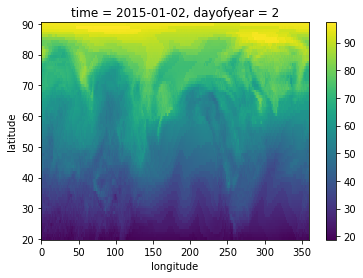

In [15]:
eff_lat_demean_actual.isel(time=1).plot()

In [17]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

for day in range(0, len(eff_lat_demean.time.values)):
    print(day)
    fig = plt.subplots(figsize=(12, 12))
    ax = plt.axes(projection=ccrs.Orthographic(20, 90))
    eff_lat_demean_actual.isel(time=day).plot.pcolormesh(ax=ax,
                                          cmap='Blues',
                                          vmin=20,
                                          vmax=90,
                                          #center=0,
                                          transform=ccrs.PlateCarree(),
                                          extend='neither',
                                          cbar_kwargs={'orientation': 'horizontal',
                                                      'pad': 0.05,
                                                      'shrink': 0.7,
                                                      'label': "Effective Latitude [degrees]",
                                                      'spacing': 'proportional'
                                                     }
                             )
    plt.tight_layout()
    ax.set_global()
    ax.coastlines()
    plt.savefig(f'{os.getenv("SCRATCH")}/figs/eff_lat/demean_eff_lat_{str(int(day)).zfill(3)}.png')
    plt.clf()

0


/scratch/midway2/ivanhigueram/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


/scratch/midway2/ivanhigueram/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

In [6]:
calculate_t_prime(path_to_raw_file='/project2/geos39650/jet_stream/data/processed_winters/ScenarioMIP_NCAR_CESM2-WACCM_ssp585_day.nc4',
                  #path_to_save='~/reanalysis_getter',
                  path_to_save='/project2/geos39650/jet_stream/data/model_output/',
                  grid_lat=0.94240838,
                  grid_lon=1.25,
                  start_year=2015,
                  end_year=2101,
                  size_year_range=10,
                  outputs=['eff_lat_deg'],
                  gcm_hack=True)

Initializing t prime calculation
Start processing -- 2015-12-01 to 2025-03-01


/scratch/midway2/ivanhigueram/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


Saving eff_lat_deg file to netcdf


KeyError: 'eff_lat_deg'

## Demean output

To remove sea-land contrast and other fixed effects, we demean the values by dubsrtacting the day-average for each of the days in our winter sample. Two process are done here. First, we take the whole mean of the timeframe. Second, we use a rolling window. 

In [38]:
paths = list(Path('/project2/geos39650/jet_stream/data/model_output/tprime/').rglob('t_prime_reanalysis*'))

In [39]:
paths

[PosixPath('/project2/geos39650/jet_stream/data/model_output/tprime/t_prime_reanalysis_1995-12-01_2000-03-01.nc4'),
 PosixPath('/project2/geos39650/jet_stream/data/model_output/tprime/t_prime_reanalysis_2015-12-01_2020-03-01.nc4'),
 PosixPath('/project2/geos39650/jet_stream/data/model_output/tprime/t_prime_reanalysis_2000-12-01_2005-03-01.nc4'),
 PosixPath('/project2/geos39650/jet_stream/data/model_output/tprime/t_prime_reanalysis_2005-12-01_2010-03-01.nc4'),
 PosixPath('/project2/geos39650/jet_stream/data/model_output/tprime/t_prime_reanalysis_2010-12-01_2015-03-01.nc4')]

In [44]:
import pandas as pd

In [57]:
#cluster.adapt(minimum=1, maximum=10)
cluster.scale(30)

In [58]:
def preprocess(ds):
    ds = ds.sortby('time')
    
    return ds 

total = xr.open_mfdataset(paths, 
                          combine='by_coords',
                          preprocess=preprocess)
total = total.rename({'__xarray_dataarray_variable__': 't_prime'})

In [ ]:
#decades = pd.to_datetime(total.time.values).year // 10 * 10
#total_decade = total.assign_coords({'decade': decades})

r = total.rolling(time=10, center=True)
r_wind = r.mean().compute()


## 3. Optional results

### 3.1 Efective latitudes


In [4]:
cluster.scale(30)

In [25]:
xarray_file = xr.open_mfdataset('/project2/geos39650/jet_stream/data/processed_winters/df_lat_20_1D.nc',
                             chunks={'time': 1})

t_df = xarray_file.to_dask_dataframe(dim_order=['time', 'latitude', 'longitude'])

eff_lat_re = area_calculation_real_area(
    dd_data=t_df,
    cut_interval=2,
    grid_lat=0.25,
    grid_lon=0.25)

# Calculate effective latitudes by using the temperature area weights
area_weights = eff_lat_re.reset_index(drop=False)

area_weights['cdf_eff_lat_mapping'] = area_weights.groupby('time').\
area_grid.apply(lambda x: dists_of_lat_eff(x))

#area_weights = area_weights[ ~ area_weights.cdf_eff_lat_mapping.isna()]
area_weights['temp_bracket'] = area_weights.temp_bracket.apply(lambda x: x.left.astype(float)).astype(float)
area_weights['eff_lat_deg'] = np.rad2deg(area_weights.cdf_eff_lat_mapping)



/scratch/midway2/ivanhigueram/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/scratch/midway2/ivanhigueram/reanalysis_env/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


In [27]:
area_weights.to_csv('/project2/geos39650/jet_stream/data/model_output/eff_lat/eff_lat_reanalysis_1980_2018.csv',
                   index=False)

In [5]:
gcm_data = xr.open_mfdataset('/project2/geos39650/jet_stream/data/processed_winters/ScenarioMIP_NCAR_CESM2-WACCM_ssp585_day.nc4',
                             chunks={'time': 1})

xarray_file = gcm_data.isel(member_id=0, nbnd=0)
    
datetime_index = xarray_file.indexes['time'].to_datetimeindex()
xarray_file['time'] = datetime_index

t_df = xarray_file.to_dask_dataframe(dim_order=['time', 'lat', 'lon'])
t_df_renamed = t_df.rename(columns={
        'lat': 'latitude',
        'lon': 'longitude',
        'tas': 't2m'
    })
t_df = t_df_renamed[['time', 'latitude', 'longitude', 't2m']]  

eff_lat_gcm = area_calculation_real_area(
    dd_data=t_df,
    cut_interval=2,
    grid_lat=0.94240838,
    grid_lon=1.25)

/scratch/midway2/ivanhigueram/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/scratch/midway2/ivanhigueram/reanalysis_env/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/scratch/midway2/ivanhigueram/reanalysis_env/lib/python3.7/site-package

In [7]:
import numpy as np
# Calculate effective latitudes by using the temperature area weights
area_weights = eff_lat_gcm.reset_index(drop=False)

area_weights['cdf_eff_lat_mapping'] = area_weights.groupby('time').\
area_grid.apply(lambda x: dists_of_lat_eff(x))

#area_weights = area_weights[ ~ area_weights.cdf_eff_lat_mapping.isna()]
area_weights['temp_bracket'] = area_weights.temp_bracket.apply(lambda x: x.left.astype(float)).astype(float)
area_weights['eff_lat_deg'] = np.rad2deg(area_weights.cdf_eff_lat_mapping)


In [8]:
area_weights.to_csv('/project2/geos39650/jet_stream/data/model_output/eff_lat/eff_lat_gcm_2015_2100.csv', index=False)

### 3.2 Sea/Land Masking

In [52]:
import regionmask
import geopandas as gpd
import numpy as np

In [ ]:
def t_prime_masker(path_file,
                   path_shape,
                   path_save,
                   level_names=None):
    
    shape = gpd.read_file(path_shape)
    shape_unary = shape.geometry.unary_union
    
    # Open array data and mask data
    array_data = xt.open_mfdataset(path_file,
                                  chunks={'time': 1})
    
    # Defensively check coordinates
    if set(['latitude', 'longitude']).issubset(array_data.coords):
        mask_shape = regionmask.Regions([land_all])
        mask = mask_shape.mask(array_data, 
                              lon_name='longitude',
                              lat_name='latitude')
    else:
        raise ValueError(f'Wrong coordinates. Coordinates available: {list(array.data.coords)}')
        


In [6]:
from dask.distributd import Client

client = Client("tcp://127.0.0.1:47874")
client

Client Scheduler: tcp://127.0.0.1:47874 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 56 Memory: 269.63 GB


In [85]:
# Mask from the shapefile
land = gpd.read_file('../shapes/continent_shapefile/continent.shp')
#land_all = land.geometry.unary_union

In [86]:
land

,CONTINENT,geometry
0,Asia,"MULTIPOLYGON (((93.27554 80.26361, 93.31304 80..."
1,North America,"MULTIPOLYGON (((-25.28167 71.39166, -25.32889 ..."
2,Europe,"MULTIPOLYGON (((58.06138 81.68776, 57.98055 81..."
3,Africa,"MULTIPOLYGON (((0.69465 5.77337, 0.66667 5.803..."
4,South America,"MULTIPOLYGON (((-81.71306 12.49028, -81.72014 ..."
5,Oceania,"MULTIPOLYGON (((-177.39334 28.18416, -177.3958..."
6,Australia,"MULTIPOLYGON (((142.27997 -10.26556, 142.21053..."
7,Antarctica,"MULTIPOLYGON (((51.80305 -46.45667, 51.72139 -..."


In [109]:
land.geometry.tolist()

In [113]:
continent_mask = regionmask.Regions(land.geometry.tolist(),
                  names=land.CONTINENT.tolist(),
                  name='Continents')
mask = continent_mask.mask(t_prime_reanalysis, 
                          lon_name='longitude',
                          lat_name='latitude')

In [91]:
land_all

In [76]:
if set(['latitude', 'longitude']).issubset(t_prime_reanalysis.coords):
    print('A')

A


In [87]:
t_prime_reanalysis = xr.open_mfdataset('/project2/geos39650/jet_stream/data/model_output/demean/demean_t_prime_1980_2020.nc4', 
                                       combine='by_coords')

mask_world_land = regionmask.Regions([land_all])
mask = mask_world_land.mask(t_prime_reanalysis, 
                          lon_name='longitude',
                          lat_name='latitude')

ValueError: setting an array element with a sequence.

In [115]:
np.unique(mask.data, return_counts=True)

(array([ 0.,  1.,  2., ..., nan, nan, nan]),
 array([78670, 57778, 23112, ...,     1,     1,     1]))

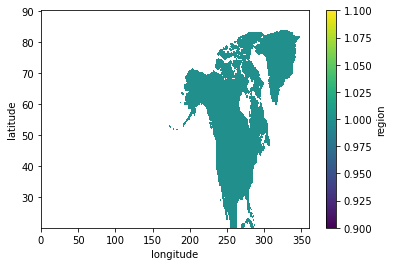

In [126]:
mask.where(mask==1).plot()

In [127]:
t_prime_asia = t_prime_reanalysis.where(mask==0)
t_prime_america = t_prime_reanalysis.where(mask==1)
t_prime_europe = t_prime_reanalysis.where(mask==2)
t_prime_africa = t_prime_reanalysis.where(mask==3)

In [128]:
path_to_save = '/project2/geos39650/jet_stream/data/model_output/demean/'
t_prime_asia.to_netcdf(f'{path_to_save}/demean_t_prime_asia_1980_2020.nc4')
t_prime_europe.to_netcdf(f'{path_to_save}/demean_t_prime_europe_1980_2020.nc4')
t_prime_america.to_netcdf(f'{path_to_save}/demean_t_prime_america_1980_2020.nc4')
t_prime_africa.to_netcdf(f'{path_to_save}/demean_t_prime_africa_1980_2020.nc4')

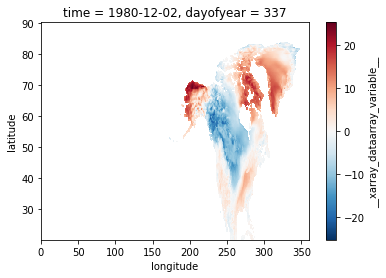

In [129]:
xr.open_dataset('/project2/geos39650/jet_stream/data/model_output/demean/demean_t_prime_america_1980_2020.nc4').__xarray_dataarray_variable__.isel(time=1).plot()

In [38]:
t_prime_sea.to_netcdf('/project2/geos39650/jet_stream/data/model_output/demean/demean_t_prime_sea_1980_2020.nc4')